In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import mitdeeplearning as mdl
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from pathlib import Path

In [18]:
from pathlib import Path
from collections import defaultdict

base_dir = Path("dataset")
splits = ["train", "validation", "test"]

for split in splits:
    split_dir = base_dir / split
    print(f"\n📂 {split_dir.name.upper()}")
    for cls in sorted(os.listdir(split_dir)):
        class_dir = split_dir / cls
        n = len([f for f in class_dir.iterdir() if f.is_file()])
        print(f"  {cls:<10}: {n} file")



📂 TRAIN
  .ipynb_checkpoints: 0 file
  gudeg     : 80 file
  gulai     : 80 file
  rendang   : 80 file
  soto      : 80 file

📂 VALIDATION
  .ipynb_checkpoints: 0 file
  gudeg     : 10 file
  gulai     : 10 file
  rendang   : 10 file
  soto      : 10 file

📂 TEST
  .ipynb_checkpoints: 0 file
  gudeg     : 10 file
  gulai     : 10 file
  rendang   : 10 file
  soto      : 10 file


In [19]:

train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")
val_dir   = os.path.join(base_dir, "validation")

# Muat dataset dari folder
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224), 
    batch_size=32,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224), 
    batch_size=10,
    shuffle=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224), 
    batch_size=10,
    shuffle=False
)


class_names = train_ds.class_names
print("Kelas:", class_names)
data_augmentation = tf.keras.Sequential([ 
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(factor=0.2),
]) 
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True)/255.0, y))
val_ds = val_ds.map(lambda x, y: (x/255.0, y))
test_ds = test_ds.map(lambda x, y: (x/255.0, y))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 322 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Kelas: ['gudeg', 'gulai', 'rendang', 'soto']


2025-10-27 16:19:55.048509: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


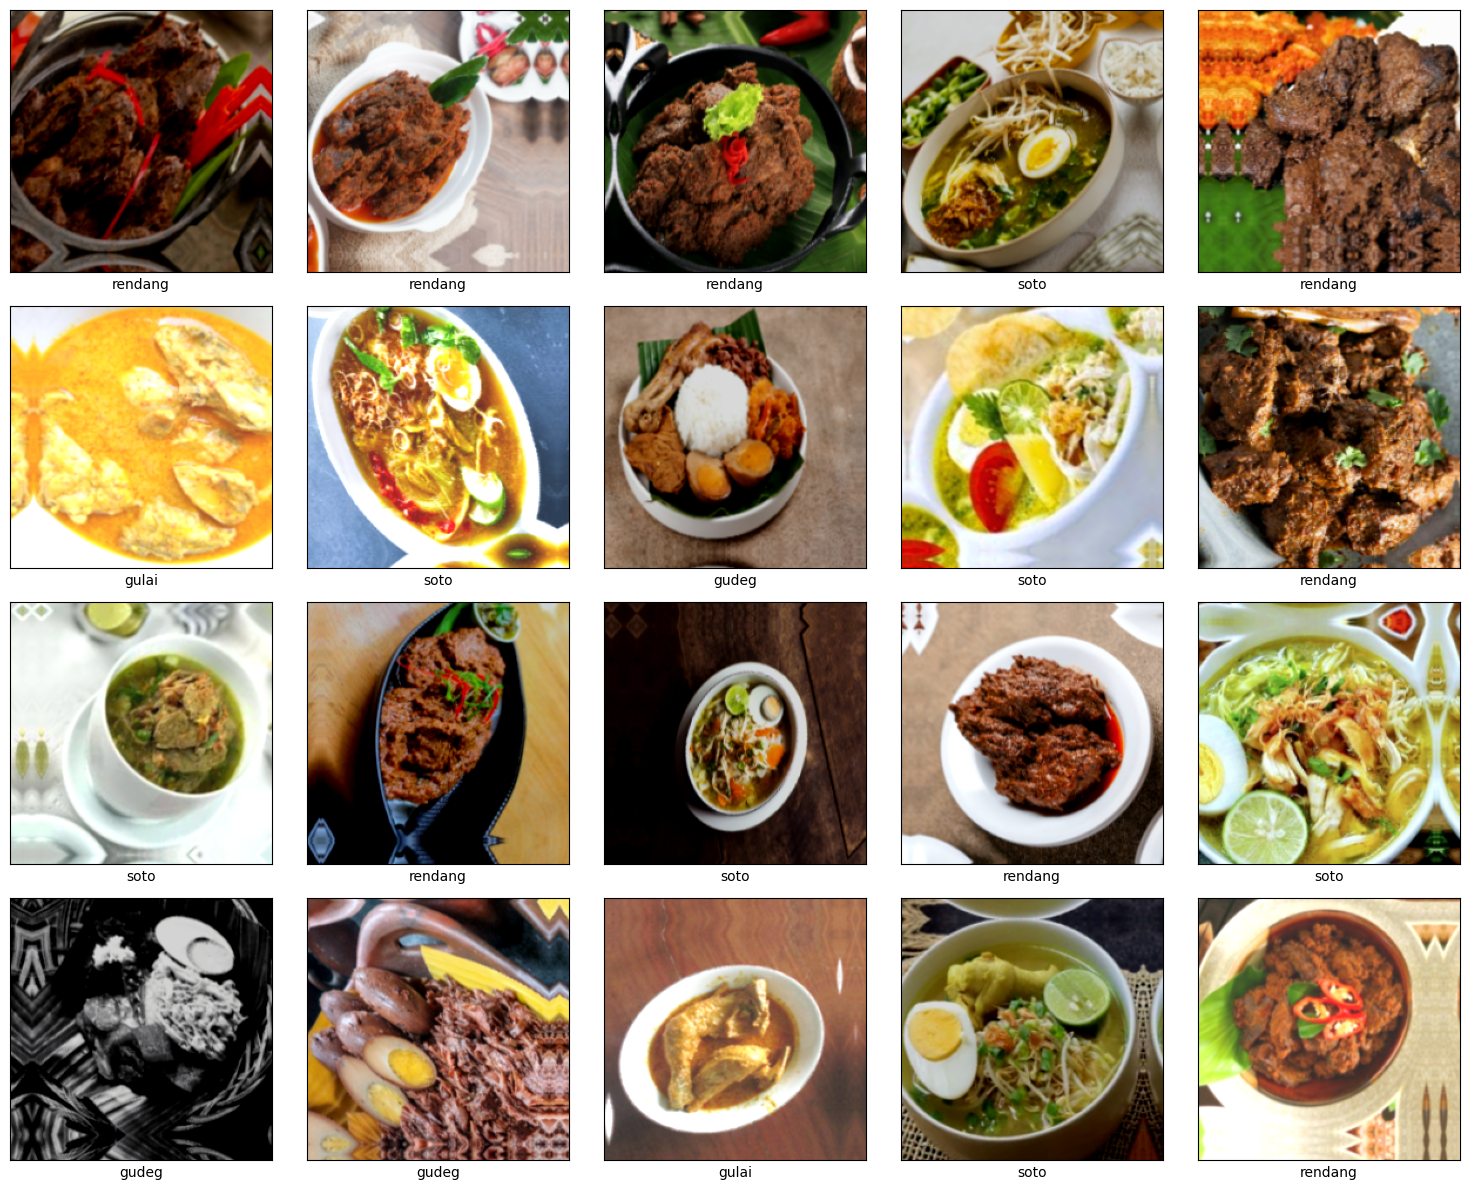

2025-10-27 16:19:55.954612: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize(dataset, num_images=20):
    for images, labels in dataset.take(1):
        n = int(min(num_images, images.shape[0]))
        idxs = np.random.choice(images.shape[0], n, replace=False)

        # grid 4x5 untuk default 20; kalau n beda, bikin grid dinamis
        rows = 4 if n >= 16 else int(np.ceil(n/5))
        cols = 5 if n >= 5  else n

        plt.figure(figsize=(3*cols, 3*rows))
        for i, idx in enumerate(idxs):
            plt.subplot(rows, cols, i + 1)
            plt.xticks([]); plt.yticks([]); plt.grid(False)
            plt.imshow(images[idx].numpy())
            label_index = int(labels[idx].numpy())
            plt.xlabel(class_names[label_index])
        plt.tight_layout()
        plt.show()


def visualize_pred(dataset, model, num_images=20):
    for images, labels in dataset.take(1):
        preds = model(images, training=False)
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        preds = tf.convert_to_tensor(preds, dtype=tf.float32)
        probs = tf.nn.softmax(preds, axis=1)
        pred_classes = tf.argmax(probs, axis=1).numpy()
        conf_scores = tf.reduce_max(probs, axis=1).numpy()  # 0..1

        n = int(min(num_images, images.shape[0]))
        idxs = np.random.choice(images.shape[0], n, replace=False)

        rows = 4 if n >= 16 else int(np.ceil(n/5))
        cols = 5 if n >= 5  else n

        plt.figure(figsize=(3*cols, 3*rows))
        for i, idx in enumerate(idxs):
            plt.subplot(rows, cols, i + 1)
            plt.xticks([]); plt.yticks([]); plt.grid(False)
            plt.imshow(images[idx].numpy())
            true_label = class_names[int(labels[idx].numpy())]
            pred_label = class_names[int(pred_classes[idx])]
            confidence = conf_scores[idx] * 100.0
            plt.xlabel(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)")
        plt.tight_layout()
        plt.show()
        
visualize(train_ds, num_images=20) 

# **Membangun Model dengan Architecture GoogLeNet**

Untuk GoogLeNet kami menggunakan referensi dari 
https://www.geeksforgeeks.org/machine-learning/understanding-googlenet-model-cnn-architecture/
yang merupakan ringkasan dari paper "Going deeper with convolutions"

Inception block yang kami gunakan adalah Inception V1

In [21]:
from tensorflow.keras import Model, Input

![image info](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*J0hM8r-FxZiG2XDiMaLqCw.png)

In [22]:
def inception_block(x, f1, f3r, f3, f5r, f5, fpp, name):
    #f1, f2, f4, dan seterusnya adalah filter
    b1 = layers.Conv2D(f1, kernel_size=(1, 1), padding="same", activation="relu", name=f"{name}_1x1")(x)

    b2 = layers.Conv2D(f3r, kernel_size=(1, 1), padding="same", activation="relu", name=f"{name}_3x3_reduce")(x)
    b2 = layers.Conv2D(f3,  kernel_size=(3, 3), padding="same", activation="relu", name=f"{name}_3x3")(b2)

    b3 = layers.Conv2D(f5r, kernel_size=(1, 1), padding="same", activation="relu", name=f"{name}_5x5_reduce")(x)
    b3 = layers.Conv2D(f5,  kernel_size=(5, 5), padding="same", activation="relu", name=f"{name}_5x5")(b3)

    b4 = layers.MaxPooling2D(pool_size=(1, 1), strides=1, padding="same", name=f"{name}_pool")(x)
    b4 = layers.Conv2D(fpp, kernel_size=(1, 1), padding="same", activation="relu", name=f"{name}_pool_proj")(b4)

    return layers.Concatenate(name=f"{name}_concat")([b1,b2,b3,b4])


In [23]:
x = tf.random.normal((1, 28, 28, 192))  # batch 1
block = inception_block(x, 64, 96, 128, 16, 32, 32, "test_block")
print("Output shape:", block.shape)


Output shape: (1, 28, 28, 256)


In [24]:
def aux_classifier(x, num_classes, name):
    y = layers.AveragePooling2D(pool_size=(5,5), strides=3, name=f"{name}_avgpool")(x)
    y = layers.Conv2D(128, kernel_size=(1,1), activation="relu", name=f"{name}_conv")(y)
    y = layers.Flatten(name=f"{name}_flat")(y)
    y = layers.Dense(1024, activation="relu", name=f"{name}_fc")(y)
    y = layers.Dropout(0.7, name=f"{name}_dropout")(y)
    y = layers.Dense(num_classes, activation="softmax", name=f"{name}_pred")(y)
    return y

Membuat model utama dari Architecture GoogLeNet
![image_info](https://media.geeksforgeeks.org/wp-content/uploads/20250715161004020299/Inception-layer-by-layer.webp)

In [25]:
class LocalResponseNorm(layers.Layer):
    def __init__(self, depth_radius=5, bias=1.0, alpha=1e-4, beta=0.75, **kwargs):
        super().__init__(**kwargs)
        self.depth_radius, self.bias, self.alpha, self.beta = depth_radius, bias, alpha, beta
    def call(self, inputs):
        return tf.nn.local_response_normalization(
            inputs, depth_radius=self.depth_radius, bias=self.bias,
            alpha=self.alpha, beta=self.beta
        )
def googlenet_stem_with_lrn(input_shape=(224,224,3)):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same", activation="relu", name="conv1_7x7")(inp)
    x = LocalResponseNorm(name="lrn1")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same", name="pool1_3x3")(x)
    x = layers.Conv2D(64, 1, padding="same", activation="relu", name="conv2_1x1")(x)
    x = layers.Conv2D(192, 3, padding="same", activation="relu", name="conv2_3x3")(x)
    x = LocalResponseNorm(name="lrn2")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same", name="pool2_3x3")(x)
    return inp, x

In [26]:
def build_googLeNet(input_shape=(224,224,3), num_classes=4, use_lrn=False):
    if use_lrn:
        inp, x = googlenet_stem_with_lrn(input_shape)
    else:
        inp = Input(shape=input_shape)
        x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding="same", activation="relu", name="conv1_7x7")(inp)
        
        x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding="same", name="pool1_3x3")(x)
    
        x = layers.Conv2D(64, kernel_size=(1, 1), padding="same", activation="relu", name="conv2_1x1")(x)
        x = layers.Conv2D(192, kernel_size=(3, 3), padding="same", activation="relu", name="conv2_3x3")(x)
        if use_lrn:
            x = tf.nn.local_response_normalization(x, depth_radius=5, bias=1, alpha=1e-4, beta=0.75, name="lrn2")
        x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding="same", name="pool2_3x3")(x)

    # ===== Inception 3 =====
    x = inception_block(x,  64,  96,128, 16, 32, 32, "inception_3a")
    x = inception_block(x, 128, 128,192, 32, 96, 64, "inception_3b")
    x = layers.MaxPooling2D(3, strides=2, padding="same", name="pool3_3x3")(x)

    # ===== Inception 4 + aux1 =====
    x = inception_block(x, 192,  96,208, 16, 48, 64, "inception_4a")
    aux1 = aux_classifier(x, num_classes, name="aux1")  

    x = inception_block(x, 160, 112,224, 24, 64, 64, "inception_4b")
    x = inception_block(x, 128, 128,256, 24, 64, 64, "inception_4c")
    x = inception_block(x, 112, 144,288, 32, 64, 64, "inception_4d")
    aux2 = aux_classifier(x, num_classes, name="aux2") 

    x = inception_block(x, 256, 160,320, 32,128,128, "inception_4e")
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding="same", name="pool4_3x3")(x)

    # ===== Inception 5 + head utama =====
    x = inception_block(x, 256, 160,320, 32,128,128, "inception_5a")
    x = inception_block(x, 384, 192,384, 48,128,128, "inception_5b")

    x = layers.GlobalAveragePooling2D(name="global_avgpool")(x)
    x = layers.Dropout(0.4, name="dropout")(x)
    main = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    return Model(inputs=inp, outputs=[main, aux1, aux2], name="GoogLeNet")


In [27]:
model = build_googLeNet(input_shape=(224,224,3), num_classes=len(class_names), use_lrn=False)
model.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_7x7 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_3x3           │ (None, 56, 56,    │          0 │ conv1_7x7[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1x1 (Conv2D)  │ (None, 56, 56,    │      4,160 │ pool1_3x3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_3x3 (Conv2D)  │ (None, 56, 56,    │    110,784 │ conv2_1x1[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2_3x3           │ (None, 28, 28,    │          0 │ conv2_3x3[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3_r… │ (None, 28, 28,    │     18,528 │ pool2_3x3[0][0]   │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_5x5_r… │ (None, 28, 28,    │      3,088 │ pool2_3x3[0][0]   │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_pool   │ (None, 28, 28,    │          0 │ pool2_3x3[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_1x1    │ (None, 28, 28,    │     12,352 │ pool2_3x3[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3    │ (None, 28, 28,    │    110,720 │ inception_3a_3x3… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_5x5    │ (None, 28, 28,    │     12,832 │ inception_3a_5x5… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_pool_… │ (None, 28, 28,    │      6,176 │ inception_3a_poo… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_concat │ (None, 28, 28,    │          0 │ inception_3a_1x1… │
│ (Concatenate)       │ 256)              │            │ inception_3a_3x3… │
│                     │                   │            │ inception_3a_5x5… │
│                     │                   │            │ inception_3a_poo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_3x3_r… │ (None, 28, 28,    │     32,896 │ inception_3a_con… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3b_5x5_r… │ (None, 28, 28,    │      8,224 │ inception_3a_con… │
│ (Conv2D)            │ 32)               │            │                 

 Total params: 10,315,580 (39.35 MB)

 Trainable params: 10,315,580 (39.35 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.optimizers import Adam
# === Compile multi-output model dengan named losses ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss={
        "predictions": "sparse_categorical_crossentropy",
        "aux1_pred": "sparse_categorical_crossentropy",
        "aux2_pred": "sparse_categorical_crossentropy",
    },
    loss_weights={
        "predictions": 1.0,
        "aux1_pred": 0.3,
        "aux2_pred": 0.3,
    },
    metrics={"predictions": ["accuracy"]},
)

# === Dataset multi-output ===
def triple_y(x, y):
    return x, (y, y, y)

train_input = train_ds.map(triple_y)
val_input   = val_ds.map(triple_y)
test_input  = test_ds.map(triple_y)

# === Training ===
history = model.fit(
    train_input,
    epochs=20,
    validation_data=val_input
)

# === Evaluasi ===
test_loss, test_acc, *_ = model.evaluate(test_input)
print("Akurasi :", test_acc)



Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - aux1_pred_loss: 1.3923 - aux2_pred_loss: 1.3895 - loss: 2.2242 - predictions_accuracy: 0.1694 - predictions_loss: 1.3895 - val_aux1_pred_loss: 1.3855 - val_aux2_pred_loss: 1.3863 - val_loss: 2.2179 - val_predictions_accuracy: 0.2500 - val_predictions_loss: 1.3863
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - aux1_pred_loss: 1.3854 - aux2_pred_loss: 1.3857 - loss: 2.2177 - predictions_accuracy: 0.2167 - predictions_loss: 1.3860 - val_aux1_pred_loss: 1.3835 - val_aux2_pred_loss: 1.3863 - val_loss: 2.2175 - val_predictions_accuracy: 0.2500 - val_predictions_loss: 1.3865
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - aux1_pred_loss: 1.3838 - aux2_pred_loss: 1.3871 - loss: 2.2187 - predictions_accuracy: 0.2364 - predictions_loss: 1.3865 - val_aux1_pred_loss: 1.3606 - val_aux2_pred_loss: 1.3862 - val_loss: 2.2110 - val_predictions_accuracy: 0.2500 - val_predictions_loss: 1.3869
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

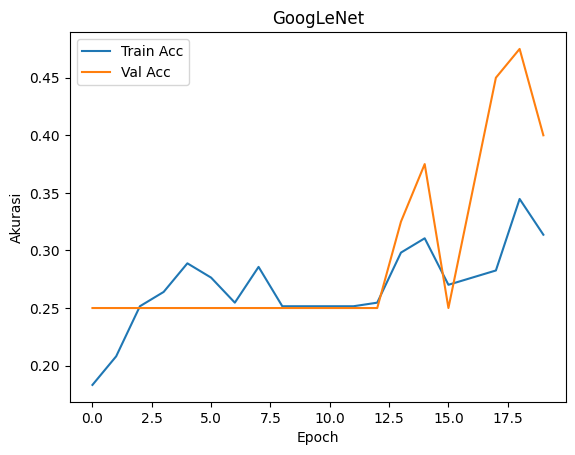

In [29]:
plt.title("GoogLeNet")
plt.plot(history.history['predictions_accuracy'], label='Train Acc')
plt.plot(history.history['val_predictions_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

   aux1_pred_loss  aux2_pred_loss      loss  predictions_accuracy  \
0        1.394224        1.391362  2.226406              0.183230   
1        1.384810        1.385456  2.219024              0.208075   
2        1.376246        1.383984  2.218354              0.251553   
3        1.395927        1.384061  2.219993              0.263975   
4        1.373280        1.384379  2.217795              0.288820   

   predictions_loss  val_aux1_pred_loss  val_aux2_pred_loss  val_loss  \
0          1.389929            1.385544            1.386298  2.217877   
1          1.385688            1.383463            1.386342  2.217457   
2          1.384766            1.360582            1.386230  2.210959   
3          1.383335            1.367160            1.387502  2.214015   
4          1.382770            1.362902            1.385363  2.212282   

   val_predictions_accuracy  val_predictions_loss  
0                      0.25              1.386324  
1                      0.25              1

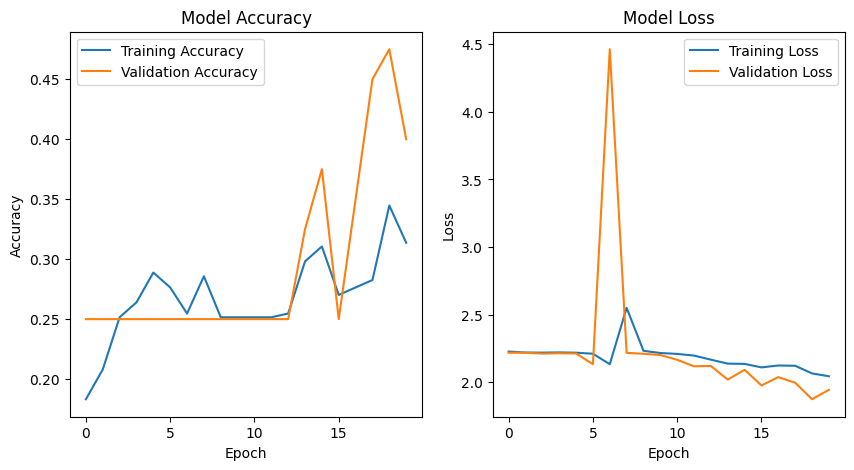

In [30]:
import pandas as pd
#Evaluasi
df_history = pd.DataFrame(history.history)
print(df_history.head())
plt.figure(figsize=(10,5))

# Accuracynya
plt.subplot(1, 2, 1)
plt.plot(df_history['predictions_accuracy'], label='Training Accuracy')
plt.plot(df_history['val_predictions_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Lossnya
plt.subplot(1, 2, 2)
plt.plot(df_history['loss'], label='Training Loss')
plt.plot(df_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

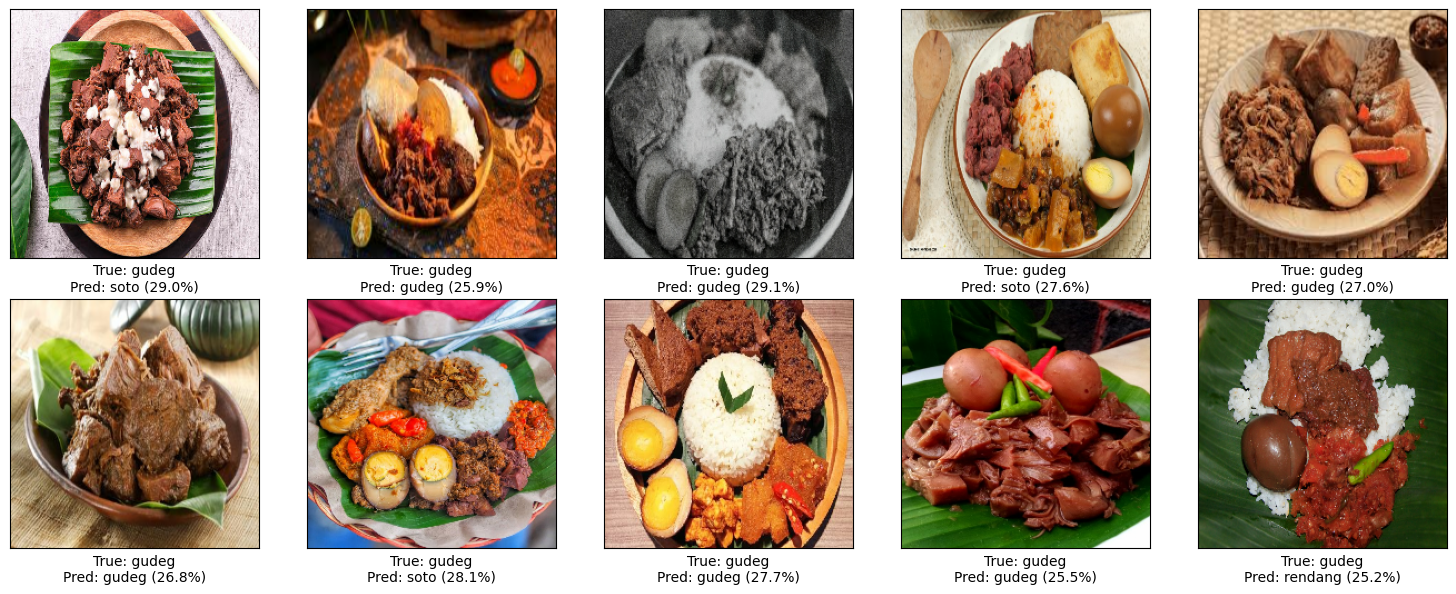

In [31]:
visualize_pred(test_ds, model, 20)    

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


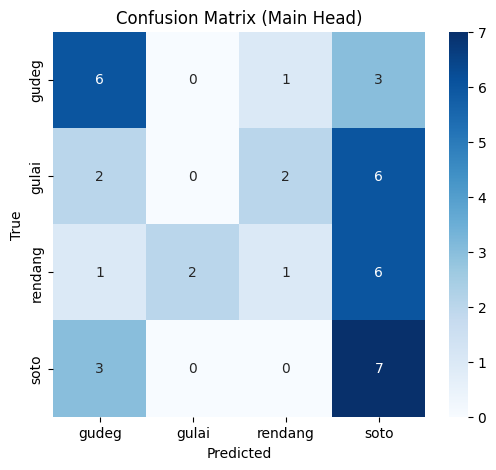

In [33]:
pred_main, pred_aux1, pred_aux2 = model.predict(test_input)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(pred_main, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Main Head)')
plt.show()


In [34]:
#menyimpan model
model.save_weights("GoogLeNet_A_AlekSnack.weights.h5")

ValueError: The filename must end in `.weights.h5`. Received: filepath=GoogLeNet_A_AlekSnack.h5